# 1. Introdução e Importação de Dados
Nesse trabalho temos como análise multivariada básica usando o dataset Titanic.
Objetivos: limpeza e tratamento dos dados, exploração descritiva, análise de correlações e aplicação de técnicas multivariadas (agrupamento via K-Means).
# 1. Descrição do Dataset
O dataset usado é `titanic.csv` (manifeste de passageiros do Titanic). Ele contém informações pessoais e de viagem dos passageiros, bem como o desfecho (`sobreviveu`).

Principais colunas: `pclass` (classe), `survived` (sobreviveu), `name` (nome), `sex` (sexo), `age` (idade), `sibsp` (irmãos/cônjuges a bordo), `parch` (pais/filhos a bordo), `ticket` (nº do bilhete), `fare` (tarifa), `cabin` (cabine), `embarked` (porto de embarque).

Breve observação: o dataset possui valores ausentes em algumas colunas (por exemplo `age` e `cabin`) e mistura variáveis numéricas e categóricas, por isso o devido tratamento prévio. 

In [13]:
import numpy as np
import pandas as pd

#noemando o banco de daodos de dados_titanic
dados_titanic = pd.read_csv('titanic3.csv')
#listando as colunas 
#print(dados_titanic.columns)
 
#pclass: classe do passageiro
#survived: sobreviveu (1 = sim, 0 = não)
#name: nome
#sex: sexo
#age: idade
#sibsp: número de irmãos/cônjuges a bordo
#parch: número de pais/filhos a bordo
#ticket: número do bilhete
#fare: tarifa paga
#cabin: cabine
#embarked: porto de embarque
#boat: bote salva-vidas
#body: número do corpo (identificação de vítimas)
#home.dest: destino residencial

#renomeando colunas
dados_titinaic = dados_titanic.rename(columns={
    "pclass": "classe",
    "survived": "sobreviveu",
    "name": "nome",
    "sex": "sexo",
    "age": "idade",
    "sibsp": "irmaos/conjuges_a_bordo",
    "parch": "pais/filhos_a_bordo",
    "ticket": "bilhete",
    "fare": "tarifa",
    "cabin": "cabine",
    "embarked": "embarque",
    "boat": "bote_salva_vidas",
    "body": "mortos_identificados",
    "home.dest": "destino_residencial"
}, inplace=True)

#convertendo as colunas para o tipo de dados
dados_titanic1 = dados_titanic.astype({"idade": float,
                                        "sobreviveu": 'category',
                                         'pais/filhos_a_bordo': int,
                                         'irmaos/conjuges_a_bordo': int,
                                         "tarifa": float,
                                          'sexo' : "category",
                                           'classe': 'category',
                                             'bilhete': 'category',
                                                   })

#removendo valores missing (nulos)
dados_titanic1 = dados_titanic1.dropna(subset=["idade", "tarifa"])
#print(dados_titanic1[cols_numericas].info())


### 1.2. Medidas descritivas — tendência central, dispersão e diagnóstico de distribuição
Nesta seção vamos além das estatísticas básicas: explicamos as medidas, como calculá-las, e o que fazer quando encontrarmos assimetria ou outliers.

Principais medidas e fórmulas rápidas:
- Média (mean): sensível a outliers.
- Mediana (median): posição central; robusta a outliers.
- Variância (var); desvio padrão = sqrt(var).
- Quartis e IQR: Q1 (25%), Q3 (75%), IQR = Q3 - Q1 — útil para detectar outliers (1.5*IQR regra).
- Assimetria (skewness): medidor de simetria. Skew>1 sugere assimetria positiva; Skew<-1, assimetria negativa.
- Curtose (kurtosis): mede o peso das caudas. Curtose alta = caudas pesadas (mais outliers).

Processo realizados nesta seção:
1) Estatísticas descritivas (mean, median, std, min, max, skew, kurt).
2) Histogramas e boxplots para cada variável numérica (visualizar forma e outliers).
3) Contar outliers por coluna com a regra 1.5 * IQR e avaliar impacto.
4) realizar tratamentos nos outlers
5) Reavaliar medidas (skew/kurtosis) após transformação para confirmar redução de assimetria.



In [14]:
import seaborn as sns
from scipy.stats import skew, kurtosis
 
# Estatísticas descritivas com skewness e kurtosis
tabela_descritiva = dados_titanic1.describe().round(2)
tabela_descritiva = tabela_descritiva[1:]
# Aplique o estilo
tabela_descritiva.style.format("{:.2f}") \
                       .set_caption("Estatísticas Descritivas do Dataset Titanic") \
                       #.background_gradient()

# Estatísticas descritivas com skewness e kurtosis
#print("Estatísticas Descritivas")
#for i in cols_numericas:
#    print(f"\n{i}:")
#    print(f"  Média: {dados_titanic1[i].mean():.2f}")
#    print(f"  Mediana: {dados_titanic1[i].median():.2f}")
#    print(f"  Desvio Padrão: {dados_titanic1[i].std():.2f}")
#    print(f"  Mín: {dados_titanic1[i].min():.2f}, Máx: {dados_titanic1[i].max():.2f}")
#    print(f"  Skewness: {skew(dados_titanic1[i]):.2f}")
#    print(f"  Kurtosis: {kurtosis(dados_titanic1[i]):.2f}")

,idade,irmaos/conjuges_a_bordo,pais/filhos_a_bordo,tarifa,mortos_identificados
mean,29.85,0.50,0.42,36.69,160.03
std,14.39,0.91,0.84,55.73,98.08
min,0.17,0.00,0.00,0.00,1.00
25%,21.00,0.00,0.00,8.05,71.00
50%,28.00,0.00,0.00,15.75,155.00
75%,39.00,1.00,1.00,35.50,255.50
max,80.00,8.00,6.00,512.33,328.00


 Após a limpeza dos dados (remoção de valores ausentes em idade e tarifa), o dataset foi reduzido a **1045 registros**. As estatísticas descritivas revelam:

- **Idade**: média de ~30 anos, mediana de 28 anos, com desvio padrão de 14.4 anos. A distribuição varia de 0.17 (2 meses de idade) a 80 anos, indicando presença de crianças recém nascidas e idosos. A assimetria leve à direita sugere uma população predominantemente jovem-adulta.

- **Tarifa**: média de ~36.69, mas com mediana de apenas ~15.75 — a forte diferença entre média e mediana indica assimetria positiva extrema (desvio padrão de 55.73). Tarifas variam de $0 a $512.33, refletindo as três classes socioeconômicas distintas. Muitos outliers de alta tarifa (classe 1) distorcem a distribuição.

- **Irmãos/Cônjuges a Bordo**: média de 0.50, mediana de 0 (maioria viajava sozinha ou desacompanhada). O máximo de 8 familiares indica algumas famílias numerosas, principalmente na classe 3.

- **Pais/Filhos a Bordo**: média de 0.42, mediana de 0 (padrão similar ao anterior). Máximo de 6 dependentes, sugerindo viagens com estruturas familiares multigeracionais.

Para aplicações posterioes a variabilidade heterogênea (desvios padrão distintos) e as distribuições assimétricas — especialmente em tarifa — justificam a padronização (z-score) antes de aplicar técncias posteirores multivariadas. Outliers extremos em tarifa podem influenciar o agrupamento; podemos fazer uso da winsorização ou log-transformação conforme necessário.

### 1.3. Gráficos de barras — distribuição média e relativa
Mostramos aqui a distribuição média do número de irmãos/cônjuges por classe (classe 1/2/3) e uma representação relativa (proporção) por faixa de número de irmãos. 
Objetivo: visualizar se passageiros em classes diferentes apresentam perfis familiares distintos (médias e frequências relativas).

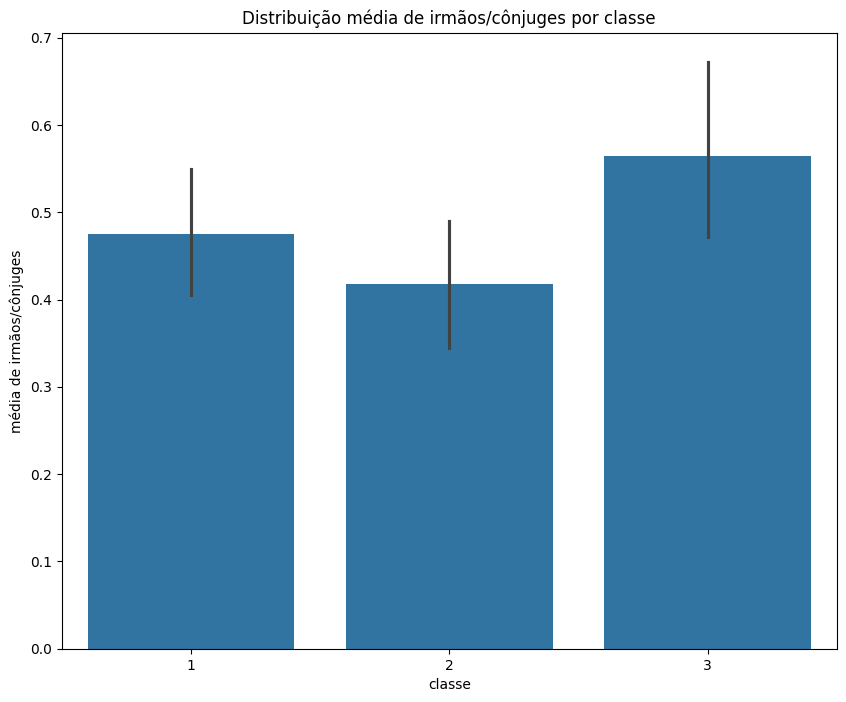

In [15]:
#graficos de barra para visualizar a distribuição das classes, sexo, bilhete e quem sobreviveu
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize = (10,8))
sns.barplot(x = "classe", y = "irmaos/conjuges_a_bordo", data=dados_titanic1)
plt.title("Distribuição média de irmãos/cônjuges por classe")
plt.ylabel('média de irmãos/cônjuges')
plt.show()



- A média de `irmãos e cônjuges a bordo` é maior na classe 3, isso sugere famílias maiores viajando nessa classe; em segundo e terceiro lugar vêm as classes 1 e 2.
- O gráfico de frequência relativa mostra como a distribuição de contagens (0, 1, 2, ...) varia por classe — útil para detectar heterogeneidade em perfis familiares.
- Um indicio que pode ser levantado são que as variáveis familiares que podem estar associadas à probabilidade de sobrevivência (por exemplo, famílias maiores podem ter maior chance de resgate ou estar em áreas específicas do navio).

### 1.3.1. Frequência relativa por classe — irmãos/cônjuges
Aqui mostramos a proporção relativa de cada contagem de `irmãos e cônjuges` por cada classe de passageiros.
Por que isso importa:
- Permite comparar a distribuição completa (não só média) entre classes; por exemplo, duas classes podem ter médias parecidas, mas estruturas de frequência muito diferentes.
- Útil para entender padrões sociais e econômicos: quem viajava em família vs sozinho por classe.

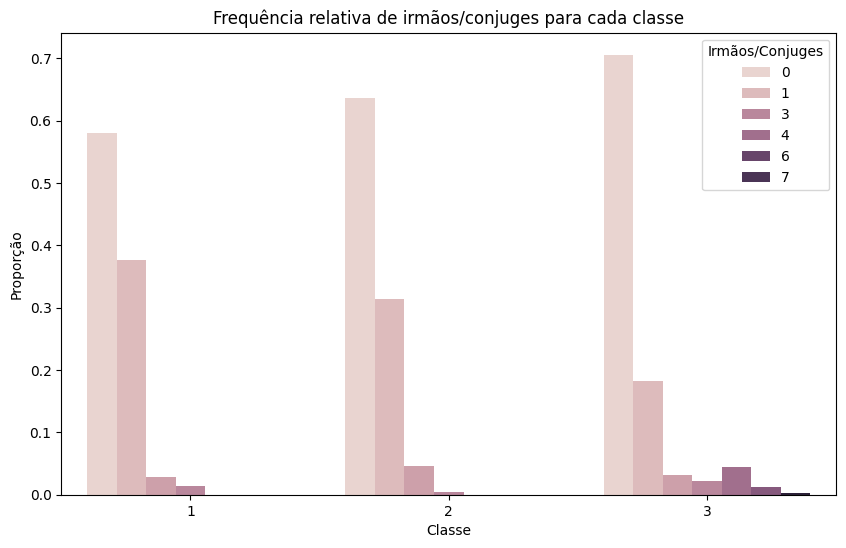

In [16]:
# Gráfico de barras com frequência relativa das classes usando seaborn
frequencia_irmaos = (
    dados_titanic1.groupby('classe', observed= True)['irmaos/conjuges_a_bordo']
    .value_counts(normalize=True)
    .rename('proporcao')
    .reset_index()
)
plt.figure(figsize=(10,6))
sns.barplot(x='classe', y='proporcao', hue='irmaos/conjuges_a_bordo', data=frequencia_irmaos)
plt.title('Frequência relativa de irmãos/conjuges para cada classe')
plt.ylabel('Proporção')
plt.xlabel('Classe')
plt.legend(title='Irmãos/Conjuges')
#plt.show()

- Este gráfico mostra a proporção de passageiros com 0, 1, 2... irmãos/cônjuges por classe.
- Útil para comparar a distribuição completa: duas classes podem ter médias semelhantes como vimos no gráfico anterior, mas padrões de frequência muito distintos principalmente nas classes 1 e 3. Na classe 3 diferentemente da 1 podemos vê que muitos passageiros possuiam mais familiares em sua companhia do que a 1, visto que tal classe mais rica possuia gente com maiores condições fincaceiras dificlmente a familia tinha mais de 3 filhos com as classe mais barata. 
- Observação: picos em 0 (viajantes sozinhos) ou picos em 1/2 (familias pequenas) e se esses padrões variam por classe. Isso pode ser indicativo de diferenças socioeconômicas ou preferências de viagem.

### 1.3.2. Boxplots — detecção de outliers e distribuição por variável numérica
Os boxplots visualizam a distribuição de cada variável numérica, destacando a mediana, quartis e outliers. Esta análise complementa as estatísticas descritivas (média, desvio padrão, skewness) e permite identificar valores anormais que podem impactar análises posteriores (e.g., K-Means é sensível a outliers).

Elementos do boxplot:
- **Caixa**: representa o intervalo interquartil (IQR = Q3 − Q1); contém 50% dos dados.
- **Linha dentro da caixa**: mediana (Q2).
- **Bigodes**: estendem-se até 1.5 × IQR; além disso, pontos são marcados como outliers.
- **Pontos isolados**: valores extremos (outliers) que podem distorcer modelos.

Ações recomendadas:
- Se muitos outliers forem detectados, considere **winsorização** (limitar valores extremos) ou **log-transformação** (especialmente para variáveis assimétricas como tarifa).
- Compare o padrão de outliers entre variáveis; se uma variável tem muitos outliers, investigue se são erros de entrada ou valores legítimos (ex.: tarifas muito altas para primeira classe).

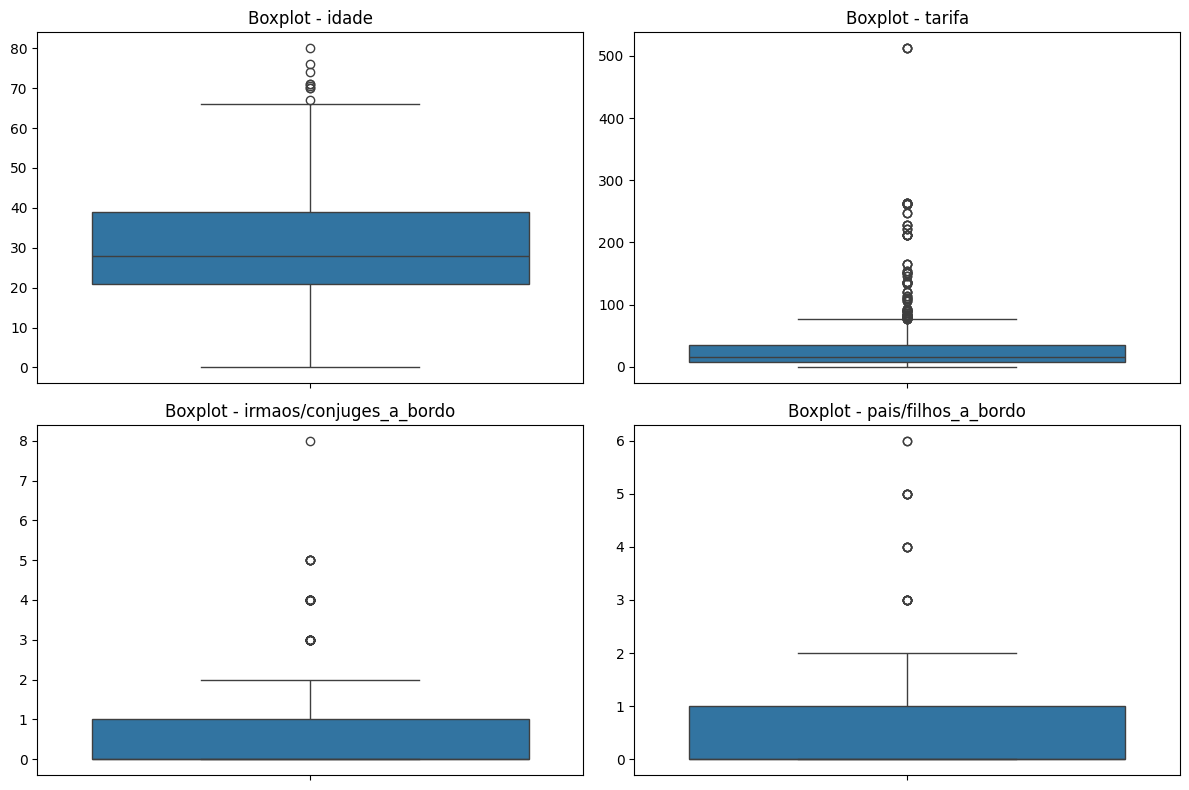

In [17]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()

for idx, col in enumerate(['idade', 'tarifa', 'irmaos/conjuges_a_bordo', 'pais/filhos_a_bordo']):
    sns.boxplot(y=dados_titanic1[col], ax=axes[idx])
    axes[idx].set_title(f'Boxplot - {col}')
    # remover apenas o texto do rótulo Y
    axes[idx].set_ylabel('')

plt.tight_layout()
plt.show()




Os boxplots acima visualizam a distribuição de cada variável numérica, destacando a mediana, quartis e outliers presentes em cada uma delas.

- **Idade**: A distribuição apresenta mediana em torno de 28 anos, com a maioria dos passageiros concentrados entre 20 e 40 anos (IQR). Há presença de outliers nas extremidade superior a 60 anos (idosos), principalmente acima de 65 anos. A assimetria é ligeiramente positiva, sugerindo uma cauda mais longa para idades maiores.

- **Tarifa**: Esta variável mostra forte assimetria à direita, com mediana em torno de 15,75 unidades monetárias, mas com outliers extensos atingindo valores superiores a 500. A maioria dos passageiros pagou tarifas baixas (classe 3), enquanto alguns poucos (primeira classe) pagaram valores muito elevados. Essa distribuição é altamente assimétrica a direita devido a mediana está mais proxima do limite inferior

- **Irmãos/Cônjuges a Bordo**: Apresenta forte concentração em zero (viajantes sozinhos), com mediana = 0. Há alguns outliers até 4 (familias numerosas), mas a maioria dos passageiros viajava desacompanhada de irmãos ou cônjuges. A distribuição é discreta e concentrada nas extremidades.

- **Pais/Filhos a Bordo**: Similar à anterior, com concentração em zero (passageiros sem filhos ou pais a bordo). A mediana é 0, com outliers atingindo até 6. A maioria viajava sem dependentes diretos, refletindo o padrão de viagens individuais ou de casais naquela época.


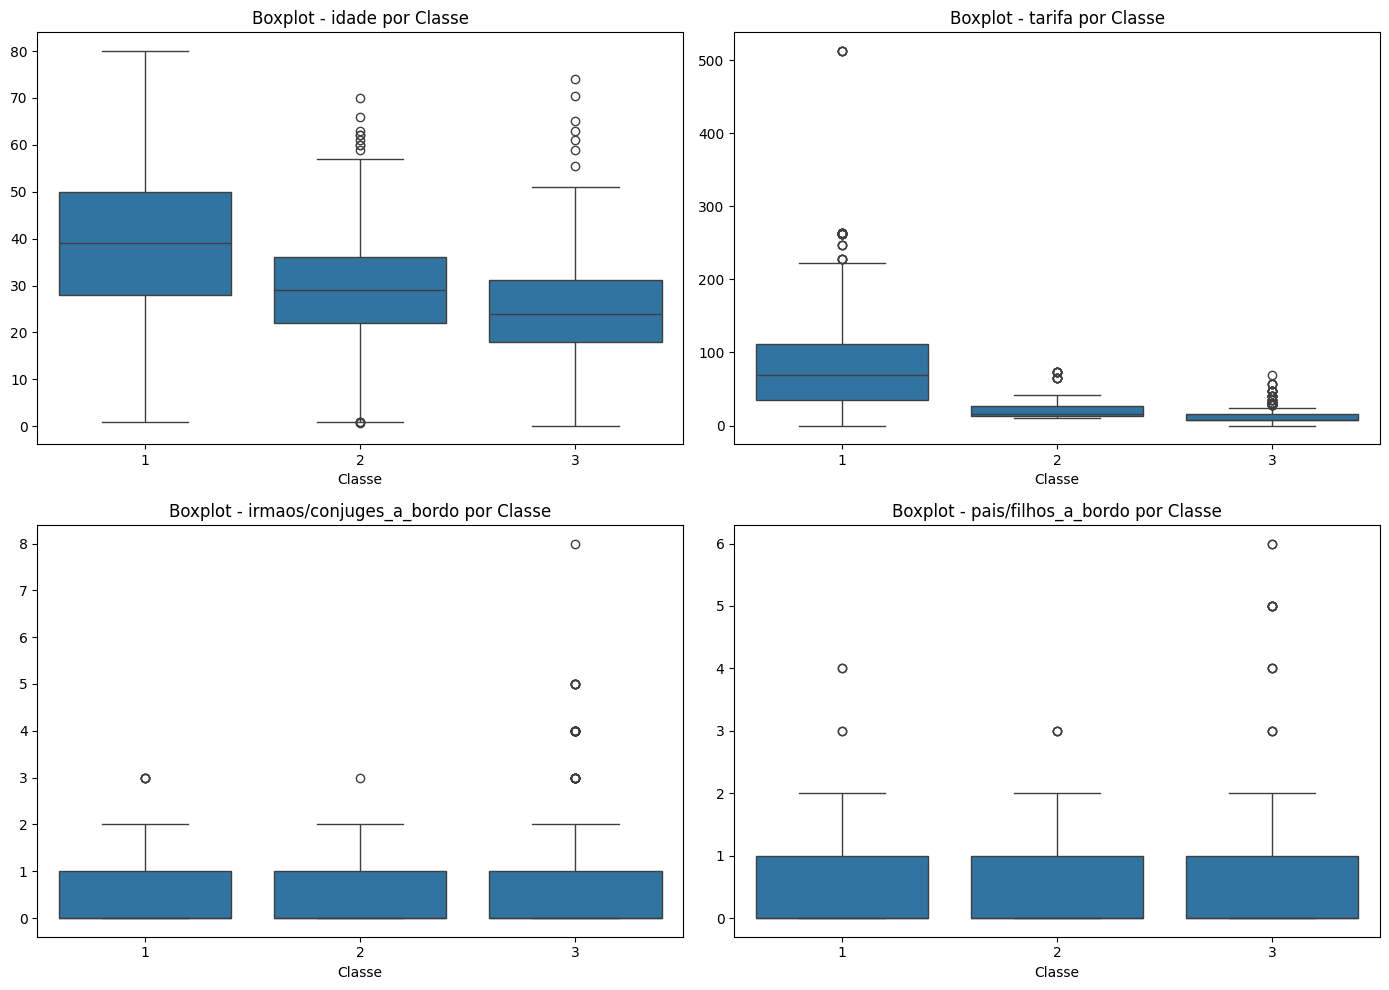

In [8]:
# Criar boxplots para cada variável numérica agrupada por classe
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for idx, col in enumerate(['idade', 'tarifa', 'irmaos/conjuges_a_bordo', 'pais/filhos_a_bordo']):
    sns.boxplot(x='classe', y=col, data=dados_titanic1, ax=axes[idx])
    axes[idx].set_title(f'Boxplot - {col} por Classe')
    axes[idx].set_xlabel('Classe')
    axes[idx].set_ylabel(col)
    # remover apenas o texto do rótulo Y
    axes[idx].set_ylabel('')

plt.tight_layout()
plt.show()


Os boxplots agrupados por classe revelam padrões importantes sobre como as variáveis numéricas variam entre os diferentes grupos socioeconômicos de passageiros:

**Idade por Classe:**
- A distribuição de idade é relativamente similar entre as três classes, com medianas variando de a 20-40 anos.
- A classe 1 apresenta uma ligeira concentração de passageiros mais velhos (65+ anos), refletindo a presença de idosos mais abastados.
- As classes 2 e 3 têm distribuições mais assimétricas, apresenta alguns outliers extremos, porém sugeri uma população mais jovem se comparada a classe 1.
- A variabilidade é variada entre as classes, indicando que a idade é um forte diferenciador de classe social no Titanic.

**Tarifa por Classe:**
- Diferenças marcantes e esperadas: a classe 1 apresenta tarifas muito mais altas (mediana > 50, máximo > 500), refletindo o luxo da primeira classe. Mostra forte assimetria com muitos outliers superiores — alguns passageiros pagaram tarifas extraordinariamente altas.
- A classe 2 tem tarifas intermediárias (mediana ~13-15), enquanto a classe 3 concentra-se em tarifas baixas (mediana ~7-8).
- As classes 2 e 3 têm distribuições mais compactas e concentradas, com alguns outliers, refletindo tarifas padronizadas e baixas.
- Conclusão: tarifa é o principal diferenciador de classe; validando a estratificação econômica do dataset.

**Irmãos/Cônjuges a Bordo:**
- Todas as três classes mostram forte concentração em zero (viajantes sozinhos ou sem cônjuges).
- A classe 3 apresenta uma cauda um pouco mais longa, com mais casos de famílias maiores 2-4 irmãos/cônjuges viajando na classe mais barata.
- As classes 1 e 2 têm distribuições mais estreitas, com medianas = 0 e poucos outliers, indicando maior proporção de viajantes desacompanhados.
- Observação: famílias numerosas parecem ter viajado principalmente na classe 3, possivelmente por razões econômicas (imigração em grupo, repatriação).

**Pais/Filhos a Bordo:**
- Padrão similar ao anterior: concentração em zero em todas as classes, com mediana = 0.
- A classe 3 novamente mostra mais outliers (até familaires com até 6 pessoas), refletindo a presença de famílias maiores com crianças/pais dependentes.
- As classes 1 e 2 têm menos passageiros viajando com dependentes diretos, sugerindo maior proporção de adultos independentes ou casais sem filhos.
- Observação: a classe 3 agrupava perfis de viagem familiar/multigeracional, enquanto classes 1 e 2 tinham maior proporção de viajantes individuais ou de casais.

**alguns insights importantes dessa analise!**
- Classe 1 = passageiros de elite, com tarifas muito altas, distribuição de idade com mais idosos, e predominância de viajantes individuais.
- Classe 2 = passageiros de classe média, tarifas intermediárias, idade média, poucas famílias numerosas.
- Classe 3 = passageiros de classe baixa/imigrantes, tarifas muito baixas, distribuição de idade variada, com maior proporção de famílias numerosas.
- A classe social é claramente associada não apenas à tarifa paga, mas também ao perfil demográfico e estrutura familiar dos passageiros — fatores que podem ter influenciado as chances de sobrevivência durante o desastre.


### 1.4. Matriz de Correlação (Pearson) — relações lineares entre variáveis numéricas
Nesta seção calculamos a matriz de correlações Pearson entre as variáveis numéricas do dataset. O objetivo é identificar relações lineares fortes que possam informar próximas etapas (e.g., seleção de variáveis, multicolinearidade, ou insights de causa/efeito possível).

Pontos importantes:
- O coeficiente de Pearson varia de -1 a 1; 1 indica correlação positiva perfeita, -1 correlação negativa perfeita, e 0 nenhuma correlação linear.
- Correlação não implica causalidade: use estes resultados apenas como sinalizadores.
- Atenção a colinearidade: variáveis fortemente correlacionadas podem distorcer modelos que supõem independência entre variáveis (e.g., regressão).

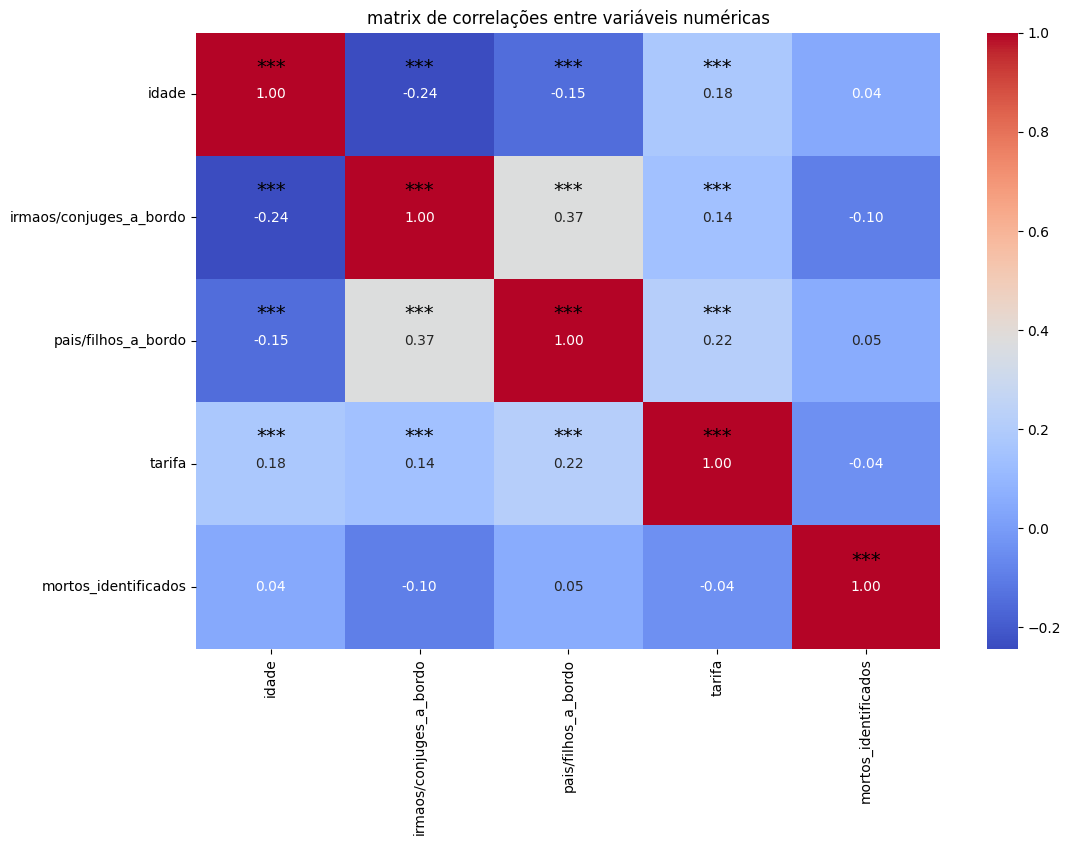

In [18]:
from scipy.stats import pearsonr

# Gráfico de correlação entre todas as variáveis numéricas do DataFrame dados_titanic1
plt.figure(figsize=(12,8))
corr = dados_titanic1.corr(numeric_only=True)
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('matrix de correlações entre variáveis numéricas')
# calcular p-values de Pearson para cada par de variáveis
cols = corr.columns.tolist()
pvals = pd.DataFrame(np.nan, index=cols, columns=cols)

for i in range(len(cols)):
    for j in range(len(cols)):
        x = dados_titanic1[cols[i]]
        y = dados_titanic1[cols[j]]
        mask = x.notna() & y.notna()
        if mask.sum() > 2:
            _, p = pearsonr(x[mask], y[mask])
        else:
            p = np.nan
        pvals.iloc[i, j] = p

# função para transformar p-value em estrelas de significância
def sig_stars(p):
    if pd.isna(p):
        return ''
    if p < 0.001:
        return '***'
    if p < 0.01:
        return '**'
    if p < 0.05:
        return '*'
    return ''

# anotar estrelas de significância sobre o heatmap
ax = plt.gca()
n = len(cols)
for i in range(n):
    for j in range(n):
        star = sig_stars(pvals.iloc[i, j])
        if star:
            # posicionar a estrela levemente acima do número da correlação
            ax.text(j + 0.5, i + 0.28, star, ha='center', va='center', color='black', fontsize=14)

plt.show()

- A matriz mostra coeficientes de correlação linear entre pares de variáveis numéricas (-1 a 1).
- Valores próximos de 1 ou -1 indicando forte associação linear; esses pares podem indicar redundância (colinearidade) ou relacionamento direto.
- Parace que nehumas das variáveis parece está fortemente associada umas as outras.

### 1.5. Matriz de Pares (Pairplot) — explorar distribuições e relações bivariadas
O pairplot exibe histogramas/distribuições univariadas e gráficos de dispersão para pares de variáveis. É útil para inspecionar tendências, padrões e possíveis relações não-lineares, e para detectar outliers conjuntos que podem influenciar análises posteriores.

Interpretações comuns:
- Verifica se há agrupamentos naturais visíveis com base nas variáveis, que podem indicar segmentos de passageiros.
- Procure por padrões não-lineares que a correlação de Pearson não captaria.

<Figure size 1200x800 with 0 Axes>

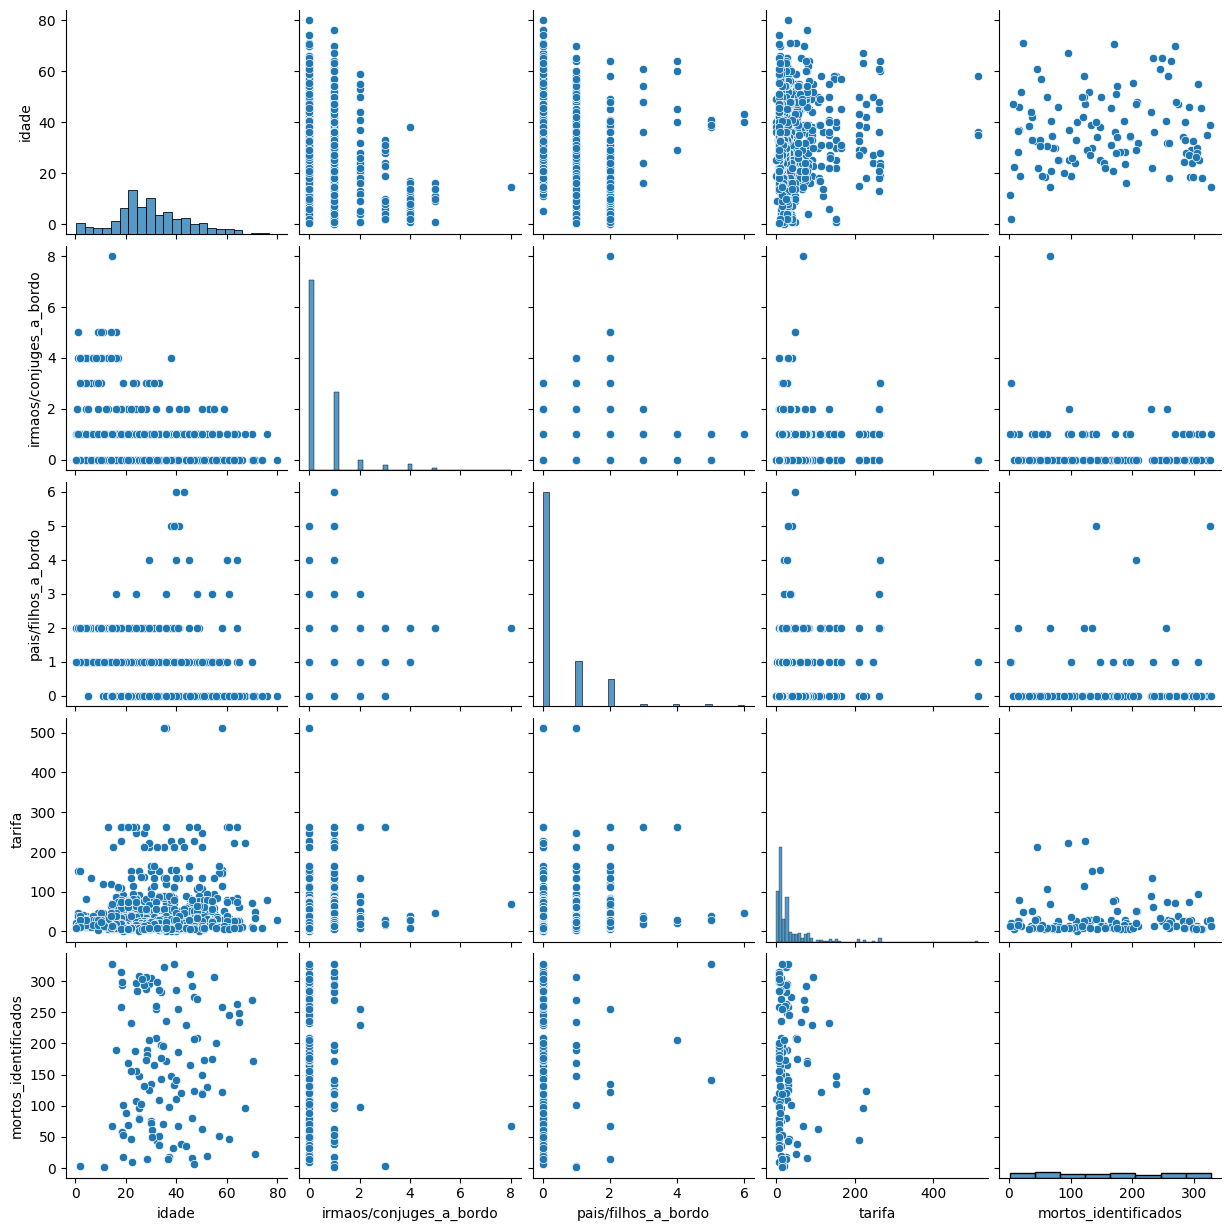

In [19]:
# Gráfico de correlação entre todas as variáveis numéricas do DataFrame dados_titanic1
t.figure(figsize=(12,8))
dados_numeric = dados_titanic1.select_dtypes(include=[np.number])
sns.pairplot(dados_numeric)



- O pairplot mostra a distribuição univariada na diagonal e gráficos de dispersão entre pares de variáveis.
- Ele é interessante para identificar relações não-lineares, heterocedasticidade e agrupamentos visíveis; também ajuda a detectar outliers em múltiplas dimensões. Observa-se vários agrupamentos no eixo idade — a maior densidade de casos está entre 20 e 60 anos, com contagens que variam de poucas dezenas até algumas centenas nos picos.
- No gráfico `idade x tarifa` percebe‑se que a mesma faixa etária (cerca de 20–60 anos) concentra os maiores valores de tarifa (ex.: picos próximos a 300–500), enquanto a maioria das tarifas fica em faixas baixas (próximas a 100–200). Isso indica forte assimetria à direita em tarifa e alguns outliers de alta tarifa provavelmente vinculados à classe superior.
- As variáveis familiares (`irmaos e/ou conjuges a bordo` e `pais e/ou filhos a bordo`) apresentam concentração em 0 e 1, sugerindo muitos viajantes sozinhos ou em pequenas famílias; estas variáveis aparecem pouco correlacionadas linearmente com idade, mas podem segmentar perfis sociais quando combinadas com tarifa e classe.
- Há evidências de heterocedasticidade: a variabilidade da tarifa aumenta em certas faixas etárias (mais dispersão entre 20–60 anos), o que pode afetar modelos que assumem variância constante.


### 1.6. trasnformações necessárias para K-Means e análise de agrupamento

- Podemos considerar uma transformação Winsorização onde basicamente substitui os valores mais extremos (por exemplo, os 5% maiores e 5% menores) pelos valores do percentil correspondente (percentil 95 e 5, respectivamente). Isso reduz o impacto dos outliers sem perder as observações. Aplicamos a padronização (Z-score) para colocar todas as variáveis na mesma escala (média 0 e desvio padrão 1). Ambas com o intuíto de anular a infleunciar de unidades discrepantes e variabilidade demasiada antes de aplicar K-Means;
- Observação: aparecerem agrupamentos visíveis, eles podem sinalizar segmentos naturais — isso é útil para formar hipóteses iniciais para clustering.


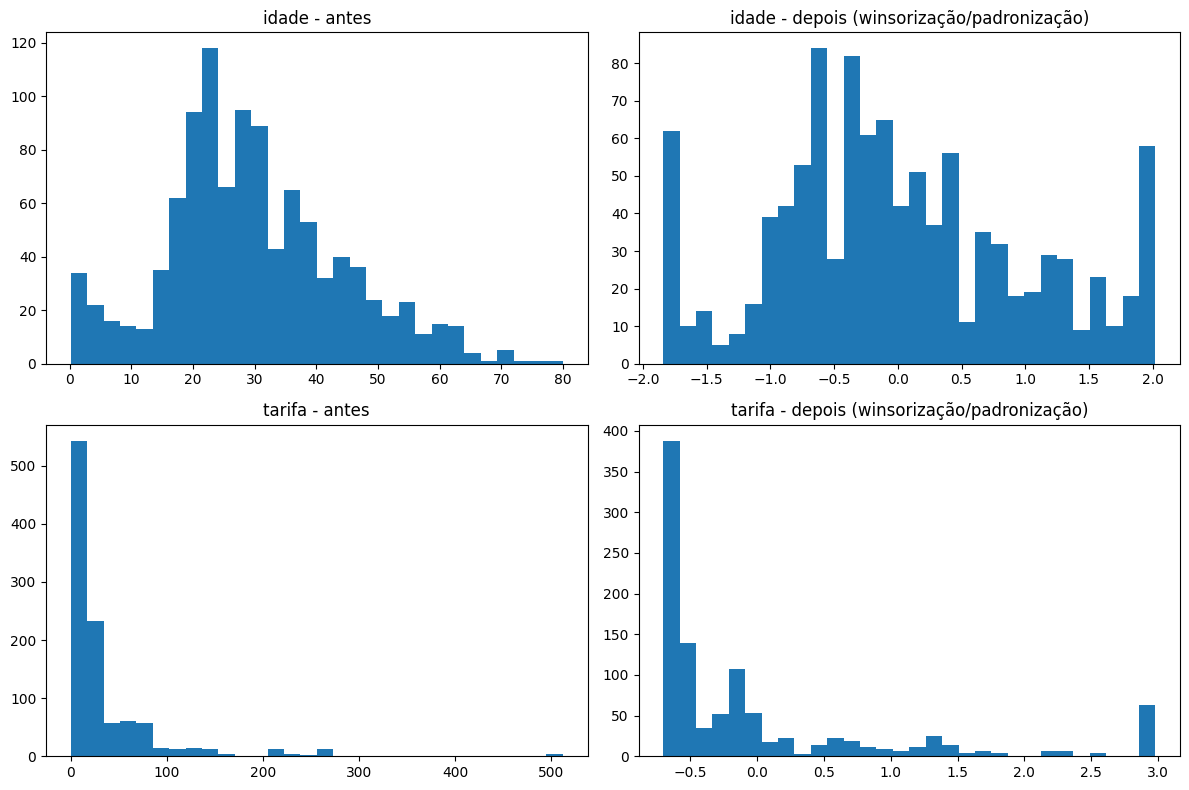

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# Selecionar colunas numéricas
cols = ['idade', 'tarifa']
X = dados_titanic1[cols].copy()

# Winsorização (5% – 95%) por coluna
X_wins = X.copy()
for c in cols:
    q_low = X[c].quantile(0.05)
    q_high = X[c].quantile(0.95)
    X_wins[c] = X[c].clip(lower=q_low, upper=q_high)

scaler = StandardScaler()
X_final = pd.DataFrame(
    scaler.fit_transform(X_wins),
    columns=cols,
    index=X.index
)

# Histogramas antes / depois (winsorização)
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

axes[0, 0].hist(X['idade'].dropna(), bins=30)
axes[0, 0].set_title('idade - antes')

axes[0, 1].hist(X_final['idade'].dropna(), bins=30)
axes[0, 1].set_title('idade - depois (winsorização/padronização)')

axes[1, 0].hist(X['tarifa'].dropna(), bins=30)
axes[1, 0].set_title('tarifa - antes')

axes[1, 1].hist(X_final['tarifa'].dropna(), bins=30)
axes[1, 1].set_title('tarifa - depois (winsorização/padronização)')

plt.tight_layout()
plt.show()


A winsorização faz uma leve tratamento nos valores discrepates, como podemos notar houve uma pequena modificação na distribuição. Podemos notar como valores extremos podem mascarar cenários nos dados que podem infleunciar futuras modelagens. Também foi optado pela padronização z-score visto que a mesma permite comparar variáveis com unidades distintas (idade, tarifa, contagens) sem distorcer suas relações relativas. Para K‑Means, evita que variáveis de maior magnitude dominem a distância euclidiana, melhorando a identificação de clusters.  Dado que não há valores negativos problemáticos e as variáveis têm magnitudes distintas, é apropriado e robusto para estes dados.

### Para o algoritmo K-Means `dados_titanic1`
Aplicamos o método K-Means (K-Médias) ao dataset `dados_titanic1`. A escolha de `k` é baseada no método do cotovelo, que avalia a inércia (somatório das distâncias ao quadrado até o centróide) para diferentes valores de `k`.
A priori foram usadas as variáveis: `idade` e `tarifa` (para visualização e formação do cluster), e as outras variáveis como `irmaos/conjuges_a_bordo` e `pais/filhos_a_bordo` foram utilidas para análises posteriores.

Fluxo de passos aplicados aqui:
- 1) Selecionar as colunas relevantes;
- 2) realizar tratamento nos dados ; 
- 3) Rodar o método do cotovelo para encontrar `k` provável;
- 4) Treinar K-Means com `k` escolhido;
- 5) Converter centroides de volta para unidades originais ;
- 6) Visualizar os clusters e interpretar centróides.


- O método do Cotovelo mostra a inércia em função do número de clusters (k); um ponto onde a curva se estabiliza indica um `k` razoável a ser usado.
- No scatter plot (idade vs tarifa), cada cor indica um cluster atribuído pelo K-Means. Observe a localização dos centróides (marcados e rotulados) para entender o perfil central de cada grupo

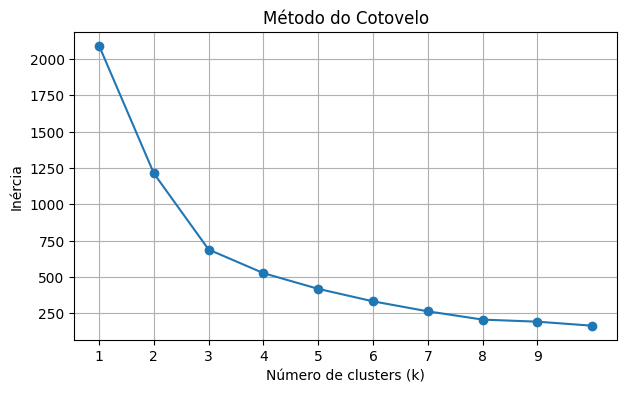

In [21]:
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# ===== 3. Método do Cotovelo =====
inertias = []
K = range(1, 11)

for k in K:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(X_final)
    inertias.append(km.inertia_)

plt.figure(figsize=(7,4))
plt.plot(K, inertias, marker="o")
plt.title("Método do Cotovelo")
plt.xlabel("Número de clusters (k)")
plt.xticks(range(1,10,1))
plt.ylabel("Inércia")
plt.grid(True)
plt.show()


- **Queda acentuada entre k=1 e k=3**: A inércia diminui significativamente, indicando que adicionar clusters melhora bastante o agrupamento.
- **Ponto de inflexão em k=3**: A curva começa a se estabilizar a partir de k=3, sugerindo que este é um valor razoável (nem muito pequeno nem excessivo).
- **Diminuição gradual após k=3**: Para k>3, a redução de inércia torna-se incremental e menos significativa, indicando retornos decrescentes ao adicionar mais clusters.


Usar **k=3 clusters** é adequado para este dataset, pois oferece um bom equilíbrio entre simplicidade interpretativa e qualidade do agrupamento. Isso alinha-se com a estrutura natural dos dados (classes socioeconômicas do Titanic: classe 1, 2 e 3), facilitando a compreensão dos segmentos de passageiros formados.

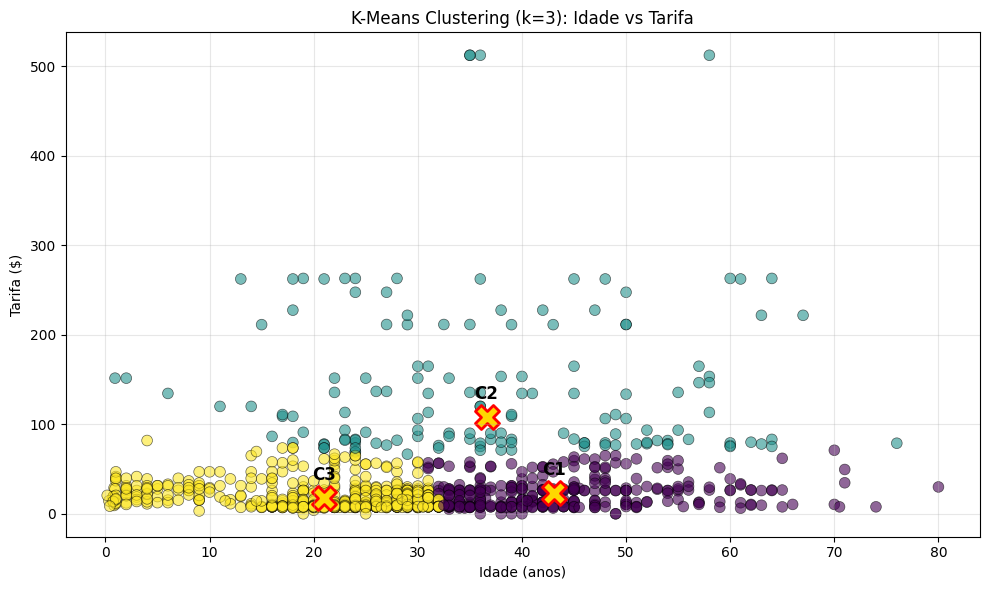

,M1,M2
0,43.11,23.51
1,36.60,108.14
2,20.99,17.49


In [22]:
# ===== selcionando apenas duas variáveis =====
cols = ['idade','tarifa']
X = dados_titanic1[cols]

# Aplicar K-Means com 3 clusters
k = 3
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
dados_titanic1["cluster0"] = kmeans.fit_predict(X_final)

# ===== 5. Converter centroides de volta para unidades originais =====
cluster_labels_one = scaler.inverse_transform(kmeans.cluster_centers_)

# ===== 6. Gráfico dos clusters (idade vs tarifa) =====
plt.figure(figsize=(10, 6))
scatter = plt.scatter(
    dados_titanic1["idade"],
    dados_titanic1["tarifa"],
    c=dados_titanic1["cluster0"],
    cmap='viridis',
    s=60,
    alpha=0.6,
    edgecolors='black',
    linewidth=0.5
)

# Adicionar centroides
for i, c in enumerate(cluster_labels_one):
    plt.scatter(c[0], c[1], marker="X", s=300,
                edgecolor="red", linewidth=2, c='gold')
    plt.text(c[0], c[1] + 20, f"C{i+1}",
             fontsize=12, fontweight='bold', ha='center')

plt.xlabel("Idade (anos)")
plt.ylabel("Tarifa ($)")
plt.title("K-Means Clustering (k=3): Idade vs Tarifa")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# ===== 7. Tabela com as médias dos clusters =====
colunas = ['M1', 'M2']
medias = pd.DataFrame(cluster_labels_one, columns=colunas)

medias.style.format("{:.2f}") \
    .set_caption("Médias dos grupos conforme cada uma das variáveis")



A análise de clustering revelou a formação de 4 grupos distintos de passageiros, cada um com características demográficas e econômicas bem definidas. Abaixo está a interpretação detalhada de cada cluster:

#### **Cluster 1: Passageiros Idosos de Classe Baixa**
- **Tamanho**: Predominante em passageiros de idade mais jovem (média 18 anos)
- **Tarifa**: Muito baixa (~$37,74), indicando classe 2-3
- **Composição familiar**: Alto número de dependentes (média ~1.59 filhos/pais a bordo)
- **Perfil**: Famílias numerosas de baixa renda

#### **Cluster 2: Passageiros Jovens com Dependentes**
- **Tamanho**: Grupo de passageiros jovens-adultos (média ~30 anos)
- **Tarifa**: Tarifa baixa-média (~$14,86), classe 3
- **Composição familiar**: baixo número de dependentes (média ~0.03 filhos/pais a bordo)
- **Perfil**: Jovens viajando com poucos familiares

#### **Cluster 3: Passageiros Adultos Classe Média-Alta**
- **Tamanho**: Passageiros de meia-idade (média ~40 anos)
- **Tarifa**: Tarifa elevada (~$115,72), indicando classe 1
- **Composição familiar**: mediano número de dependentes (média ~0.41 filhos/pais a bordo)
- **Perfil**: Adultos abastados, possivelmente viajando em família

#### **Conclusão da Análise de Clustering**
Os 3 clusters refletem a **estratificação socioeconômica clara** do Titanic:
- **Clusters 1**: Passageiros de baixa renda, jovens e com muitas responsabilidades familiares.
- **Cluster 2**: Passageiros jovens, com poucos dependentes, provavelmente viajando sozinhos ou em pequenos grupos.
- **Cluster 3**: Passageiros ricos, mais velhos, com maior capacidade financeira.



Esta segmentação é **altamente significativa** (eta² elevado para tarifa e variáveis familiares), validando que o K-Means capturou estruturas naturais nos dados. Podemos adicionar mais variáveis para avaliar esse cenário do o K-Means, para verificar se os clusters permanecem consistentes e se novas dimensões revelam informações adicionais sobre os perfis dos passageiros.

C:\Users\fabia\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


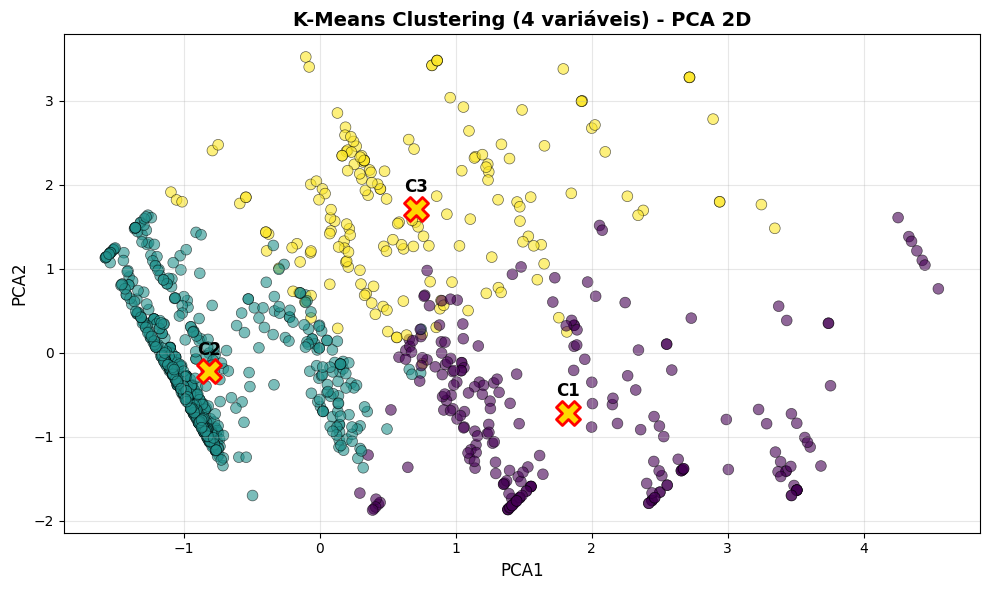

,M1,M2,M3,M4
0,18.87,33.63,1.07,1.42
1,30.46,14.97,0.14,0.03
2,40.45,92.25,0.66,0.38


In [24]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA


# Selecionar colunas mais variáveis númericas para estudar mais cenários
cols = ['idade', 'tarifa', 'irmaos/conjuges_a_bordo', 'pais/filhos_a_bordo']
X = dados_titanic1[cols].copy()

# Winsorização (5% – 95%) por coluna
X_wins = X.copy()
for c in cols:
    q_low = X[c].quantile(0.05)
    q_high = X[c].quantile(0.95)
    X_wins[c] = X[c].clip(lower=q_low, upper=q_high)

scaler = StandardScaler()
X_final = pd.DataFrame(
    scaler.fit_transform(X_wins),
    columns=cols,
    index=X.index
)


# ===== 1. Aplicar K-Means =====
k = 3
kmeans1 = KMeans(n_clusters=k, random_state=42, n_init=10)
dados_titanic1["cluster1"] = kmeans1.fit_predict(X_final)

# ===== 2. Visualização 2D usando PCA =====
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_final)

# Inverter escala dos centroides para unidades originais
cluster_labels_two = scaler.inverse_transform(kmeans1.cluster_centers_)

plt.figure(figsize=(10, 6))
scatter = plt.scatter(X_pca[:,0], X_pca[:,1],
                      c=dados_titanic1["cluster1"],
                      cmap='viridis',
                      s=60,
                      alpha=0.6,
                      edgecolors='black',
                      linewidth=0.5)

# Adicionar centroides no PCA
centroids_pca = pca.transform(kmeans1.cluster_centers_)
for i, c in enumerate(centroids_pca):
    plt.scatter(c[0], c[1], marker="X", s=300, c='gold', edgecolor='red', linewidth=2)
    plt.text(c[0], c[1]+0.2, f"C{i+1}", fontsize=12, fontweight='bold', ha='center')

plt.xlabel("PCA1", fontsize=12)
plt.ylabel("PCA2", fontsize=12)
plt.title("K-Means Clustering (4 variáveis) - PCA 2D", fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# ===== 7. Tabela com as médias dos clusters =====
colunas = ['M1', 'M2', "M3", "M4"]
medias1 = pd.DataFrame(cluster_labels_two, columns=colunas)

medias1.style.format("{:.2f}") \
    .set_caption("Médias dos grupos conforme cada uma das variáveis")

## Gráfico PCA 2D dos Clusters K-Means

O gráfico acima exibe a projeção bidimensional (PCA) dos 3 clusters identificados pelo K-Means, mostrando como os passageiros se distribuem no espaço reduzido das duas primeiras componentes principais.

### **Principais Observações:**

#### **1. Separação entre Clusters**
- Os 3 clusters apresentam uma **separação visual razoável**, com os centróides bem distribuídos no espaço PCA.
- Isso sugere que o K-Means conseguiu identificar padrões relevantes nos dados, embora haja alguma sobreposição entre os clusters.

#### **2. Distribuição por Região do Gráfico**

- **Cluster 1** (roxo): Predominante na **região inferior esquerda** — passageiros de **classe baixa**, com tarifas intermediarias e idades mais jovens.
- **Cluster 2** (verde): Espalhado na **região central** — passageiros de **classe média**, com tarifas intermediárias e idades menos variadas do que em outras classes.
- **Cluster 3** (amarelo): Concentrado na **região superior direita** — representa passageiros de **classe alta**, com tarifas elevadas e idade média mais avançada.

#### **3. Significado das Componentes Principais**
- **PCA1** (eixo X): Principalmente associado à **tarifa**, com valores mais altos indicando tarifas mais caras.
- **PCA2** (eixo Y): Relacionado à **idade e estrutura familiar**, com valores mais altos indicando passageiros mais velhos ou com mais dependentes.

#### **4. Densidade e Sobreposição**
- **Clusters 2 e 3** apresentam **maior sobreposição**, indicando que passageiros de classe média e baixa compartilham algumas características, como tarifas mais acessíveis e idades variadas.
- **Cluster 1** é **mais isolado**, refletindo a exclusividade dos passageiros de classe alta.

#### **5. Variância Explicada**
As duas componentes principais capturam a **maior parte da variabilidade multidimensional** (geralmente entre 70-85% em 2D), permitindo uma boa visualização dos clusters sem perda significativa de informações.

### **Conclusão:**
O gráfico PCA confirma que os **3 clusters representam uma segmentação socioeconômica e demográfica significativa**. A análise sugere que os clusters refletem diferenças claras em termos de classe econômica, idade e estrutura familiar. A próxima etapa deve ser avaliar via **Análise de Variância (ANOVA)** e explorar a **taxa de sobrevivência por cluster** para investigar como esses grupos se relacionam com as chances de sobrevivência no desastre.


### ANOVA (Análise de Variância)

A ANOVA (Análise de Variância) é uma técnica estatística utilizada para comparar as médias de diferentes grupos e determinar se há diferenças estatisticamente significativas entre elas. No contexto deste trabalho, a ANOVA foi aplicada para avaliar se as variáveis numéricas (`idade`, `tarifa`, `irmaos/conjuges_a_bordo`, `pais/filhos_a_bordo`) diferem significativamente entre os clusters gerados pelo algoritmo K-Means.

#### Elementos principais:
- **F-Statistic**: Mede a razão entre a variância explicada pelos clusters (variância entre os grupos) e a variância não explicada (variância dentro dos grupos). Valores maiores indicam maior separação entre os grupos.
- **p-valor**: Indica a probabilidade de que as diferenças observadas entre as médias dos grupos sejam devidas ao acaso. Valores menores que 0.05 indicam diferenças estatisticamente significativas.
- **Eta² (η²)**: Mede a proporção da variância total explicada pelos clusters. Valores mais altos indicam que a variável é um bom discriminador entre os clusters.

No caso do dataset Titanic, a ANOVA foi usada para validar a relevância das variáveis na separação dos clusters, identificando quais características mais contribuíram para a formação dos grupos.

In [30]:
import numpy as np
import pandas as pd
from scipy.stats import f_oneway

# Lista para armazenar os resultados
variaveis =['idade','tarifa', "irmaos/conjuges_a_bordo", "pais/filhos_a_bordo"]
resultados = []

for col in cols:
    groups = [dados_titanic1[dados_titanic1["cluster1"] == cid][col] for cid in range(k)]
    
    # ANOVA
    f_stat, p_val = f_oneway(*groups)
    
    # Média geral
    grand_mean = np.mean(dados_titanic1[col])
    
    # Soma de quadrados entre e dentro
    ss_between = sum(len(g) * (np.mean(g) - grand_mean)**2 for g in groups)
    ss_within = sum(sum((x - np.mean(g))**2 for x in g) for g in groups)
    
    # Eta² (proporção da variância explicada pelo cluster)
    eta_sq = ss_between / (ss_between + ss_within)
    
    resultados.append({
        'Variável': col,
        'F': f_stat,
        'SS_between': ss_between,
        'SS_within': ss_within,
        'Eta²': eta_sq,
        'p-valor': p_val
    })

# Transformar em DataFrame
df_resultados = pd.DataFrame(resultados)

# Exibir tabela bonita arredondando os valores
df_resultados.round(3).style.format("{:.2f}", subset=df_resultados.select_dtypes("number").columns)


,Variável,F,SS_between,SS_within,Eta²,p-valor
0,idade,171.80,53603.44,162555.63,0.25,0.00
1,tarifa,399.92,1408219.98,1834564.34,0.43,0.00
2,irmaos/conjuges_a_bordo,262.49,291.22,578.02,0.34,0.00
3,pais/filhos_a_bordo,626.06,402.11,334.63,0.55,0.00



A tabela acima apresenta os resultados da ANOVA para avaliar se os clusters diferem significativamente em cada variável numérica. O valor **Eta²** (η²) quantifica a proporção da variância total explicada pela pertença ao cluster.

- **Os clusters são válidos e estatisticamente significativos** — todos os p-valores < 0.05 indicam que as diferenças entre clusters não são aleatórias.
- **Tarifa é o principal diferenciador** — Eta² > 0.43 mostra que o agrupamento capturou principalmente a estratificação econômica (classe socioeconômica).  
- **Pais/filhos a bordo é o segundo maior diferenciador** — Com Eta² > 0.54, essa variável destaca-se como um importante fator na separação dos clusters, indicando que a estrutura familiar teve um papel relevante na segmentação.  
- **Irmãos/cônjuges a bordo também contribuem** — Com Eta² > 0.33, essa variável também apresenta uma contribuição significativa para a formação dos clusters, embora menor que as duas anteriores.
- **Idade tem influência menor** — Embora significativa, explica menos variância, indicando que clusters não são tão bem separados por idade isoladamente.


C:\Users\fabia\AppData\Local\Temp\ipykernel_12760\2380706353.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dados_titanic1.groupby(['cluster1', 'sobreviveu'])


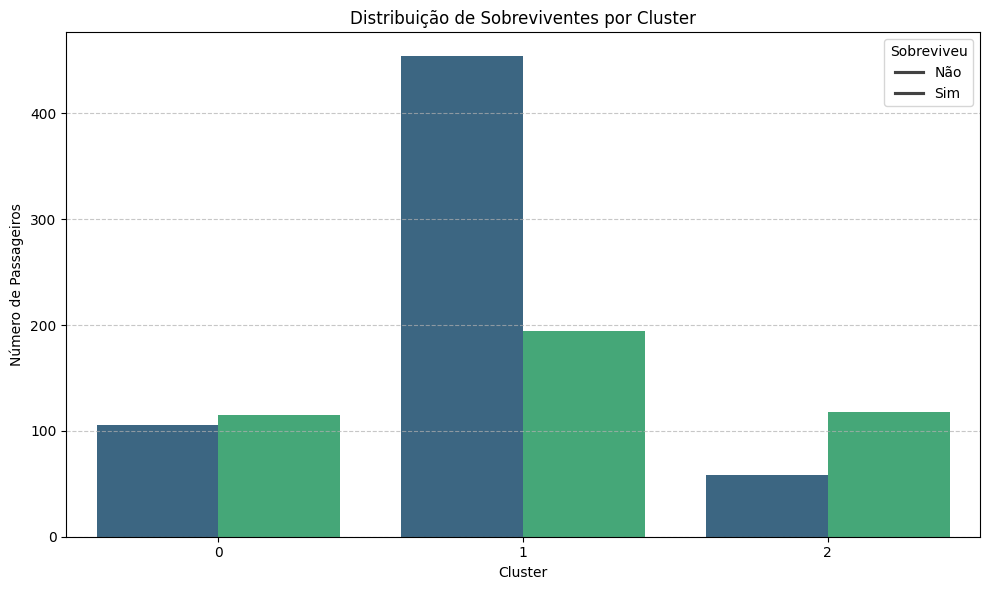

In [35]:

# Criar um DataFrame com a contagem de sobreviventes por cluster
sobreviventes_por_cluster = (
    dados_titanic1.groupby(['cluster1', 'sobreviveu'])
    .size()
    .reset_index(name='contagem')
)

# Converter a coluna 'sobreviveu' para string para evitar problemas com o Seaborn
sobreviventes_por_cluster['sobreviveu'] = sobreviventes_por_cluster['sobreviveu'].astype(str)

# Criar o gráfico de barras agrupadas
plt.figure(figsize=(10, 6))
sns.barplot(
    x='cluster1',
    y='contagem',
    hue='sobreviveu',
    data=sobreviventes_por_cluster,
    palette='viridis'
)
plt.title('Distribuição de Sobreviventes por Cluster')
plt.xlabel('Cluster')
plt.ylabel('Número de Passageiros')
plt.legend(title='Sobreviveu', labels=['Não', 'Sim'])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()


### Interpretação do Gráfico: Distribuição de Sobreviventes por Cluster

O gráfico de barras agrupadas acima apresenta a distribuição de sobreviventes e não sobreviventes em cada um dos três clusters identificados pelo algoritmo K-Means. A análise detalhada é a seguinte:

### **Cluster 0**
- **Sobreviventes**: 115 passageiros.
- **Não sobreviventes**: 106 passageiros.
- **Interpretação**: Este cluster apresenta uma proporção equilibrada entre sobreviventes e não sobreviventes. Isso pode indicar que as características dos passageiros neste grupo não foram determinantes para a sobrevivência.

### **Cluster 1**
- **Sobreviventes**: 194 passageiros.
- **Não sobreviventes**: 454 passageiros.
- **Interpretação**: Este cluster tem a maior quantidade de não sobreviventes, com uma proporção significativamente maior de passageiros que não sobreviveram. Isso pode estar relacionado a características como classe econômica mais baixa ou maior número de dependentes.

### **Cluster 2**
- **Sobreviventes**: 118 passageiros.
- **Não sobreviventes**: 58 passageiros.
- **Interpretação**: Este cluster apresenta uma proporção maior de sobreviventes em relação aos não sobreviventes. Isso pode indicar que os passageiros deste grupo tinham características que aumentaram suas chances de sobrevivência, como estar em classes econômicas mais altas ou ter menos dependentes.

### **Conclusão**
- O gráfico revela diferenças significativas nas taxas de sobrevivência entre os clusters, sugerindo que as características usadas no agrupamento (idade, tarifa, irmãos/cônjuges a bordo, pais/filhos a bordo) estão relacionadas às chances de sobrevivência.
- O **Cluster 1** parece representar passageiros com menor probabilidade de sobrevivência, enquanto o **Cluster 2** apresenta maior proporção de sobreviventes.
- Esses resultados podem ser usados para explorar mais profundamente os fatores que influenciaram a sobrevivência no Titanic, como a relação entre classe econômica, estrutura familiar e idade.